#A fórmula de Joel Greenblatt

In [ ]:
!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf

# Importando Bibliotecas

In [2]:
import numpy as np
import pandas as pd
import string
import warnings
warnings.filterwarnings('ignore')

import requests

# Obtendo e processando os dados

##Acessando os dados do site Fundamentus

In [3]:
url = 'https://www.fundamentus.com.br/resultado.php'

In [4]:
header = {
  "User-Agent": "Safari/537.36"  
 }

r = requests.get(url, headers=header)

In [5]:
df = pd.read_html(r.text,  decimal=',', thousands='.')[0]

In [6]:
df.head(3)

,Papel,Cotação,P/L,P/VP,PSR,Div.Yield,P/Ativo,P/Cap.Giro,P/EBIT,P/Ativ Circ.Liq,EV/EBIT,EV/EBITDA,Mrg Ebit,Mrg. Líq.,Liq. Corr.,ROIC,ROE,Liq.2meses,Patrim. Líq,Dív.Brut/ Patrim.,Cresc. Rec.5a
0,VNET3,0.0,0.0,0.0,0.0,"0,00%",0.0,0.0,0.0,0.0,0.0,0.0,"0,00%","0,00%",0.0,"0,00%","7,61%",0.0,9.145920e+09,0.00,"-5,18%"
1,CFLU4,1000.0,0.0,0.0,0.0,"0,00%",0.0,0.0,0.0,0.0,0.0,0.0,"8,88%","10,72%",1.1,"17,68%","32,15%",0.0,6.035100e+07,0.06,"8,14%"
2,CLAN3,0.0,0.0,0.0,0.0,"0,00%",0.0,0.0,0.0,0.0,0.0,0.0,"0,00%","0,00%",0.0,"0,00%","-1,05%",0.0,1.012240e+09,0.00,"-63,96%"


In [7]:
# 889 linhas e 21 colunas #
df.shape

(889, 21)

In [8]:
# Alterando nas colunas os dados tipo string para tipo Float #
for coluna in ['Div.Yield', 'Mrg Ebit', 'Mrg. Líq.', 'ROIC', 'ROE', 'Cresc. Rec.5a']:
  df[coluna] = df[coluna].str.replace('.', '')
  df[coluna] = df[coluna].str.replace(',', '.')
  df[coluna] = df[coluna].str.rstrip('%').astype('float') / 100

In [9]:
df.head(2)

,Papel,Cotação,P/L,P/VP,PSR,Div.Yield,P/Ativo,P/Cap.Giro,P/EBIT,P/Ativ Circ.Liq,EV/EBIT,EV/EBITDA,Mrg Ebit,Mrg. Líq.,Liq. Corr.,ROIC,ROE,Liq.2meses,Patrim. Líq,Dív.Brut/ Patrim.,Cresc. Rec.5a
0,VNET3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0761,0.0,9.145920e+09,0.00,-0.0518
1,CFLU4,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0888,0.1072,1.1,0.1768,0.3215,0.0,6.035100e+07,0.06,0.0814


# Analisando os dados

In [10]:
# Excluindo empresas com movimentação liquida menor que 100000,00 nos últimos dois meses #
df = df[df['Liq.2meses'] > 1000000]

In [11]:
df.head(2)

,Papel,Cotação,P/L,P/VP,PSR,Div.Yield,P/Ativo,P/Cap.Giro,P/EBIT,P/Ativ Circ.Liq,EV/EBIT,EV/EBITDA,Mrg Ebit,Mrg. Líq.,Liq. Corr.,ROIC,ROE,Liq.2meses,Patrim. Líq,Dív.Brut/ Patrim.,Cresc. Rec.5a
13,OMGE3,39.00,-10841.80,2.40,6.575,0.0,0.859,11.26,20.21,-1.69,31.68,19.30,0.3253,0.0048,2.46,0.0473,-0.0002,32131300.0,2.762890e+09,1.62,0.7027
15,SQIA3,23.56,-919.32,3.93,8.973,0.0,2.730,5.14,2973.41,8.58,2509.56,79.29,0.0030,-0.0097,6.81,0.0021,-0.0043,21874900.0,4.232550e+08,0.19,0.2446


In [12]:
# Montando um ranking com base nas colunas EV/EBIT e ROIC #
ranking = pd.DataFrame()
ranking['pos'] = range(1,166)
# EV/EBIT #
ranking['EV/EBIT'] = df[ df['EV/EBIT'] > 0 ].sort_values(by=['EV/EBIT'])['Papel'][:165].values
# ROIC #
ranking['ROIC'] = df.sort_values(by=['ROIC'], ascending=False)['Papel'][:165].values
##BOVA11 1 ano / "Adj Close"
ibov = yf.download('BOVA11.SA', period='1y')["Adj Close"]
ibov = ibov / ibov.iloc[0]

[*********************100%***********************]  1 of 1 completed


In [13]:
# Ranking EV/EBIT #
ebit = ranking.pivot_table(columns='EV/EBIT', values='pos')

In [14]:
ebit.head(1)

EV/EBIT,AALR3,ABEV3,AGRO3,ALPA4,ALSO3,ALUP11,AMAR3,ANIM3,ARZZ3,B3SA3,BEEF3,BKBR3,BRDT3,BRFS3,BRKM5,BRML3,BRPR3,CAMB3,CAML3,CARD3,CCPR3,CCRO3,CEAB3,CESP6,CIEL3,CLSC4,CMIG3,CMIG4,CNTO3,COCE5,COGN3,CPFE3,CPLE3,CPLE6,CRFB3,CSAN3,CSMG3,CSNA3,CVCB3,CYRE3,...,SAPR3,SAPR4,SBSP3,SEER3,SGPS3,SHUL4,SLCE3,SMLS3,SMTO3,STBP3,SULA11,SUZB3,TAEE11,TAEE4,TASA4,TEND3,TESA3,TGMA3,TIET11,TIET3,TIET4,TIMP3,TOTS3,TRIS3,TRPL4,TUPY3,UGPA3,UNIP6,USIM3,USIM5,VALE3,VIVT3,VIVT4,VLID3,VULC3,VVAR3,WEGE3,WIZS3,WSON33,YDUQ3
pos,119.0,92.0,70.0,141.0,68.0,6.0,41.0,128.0,142.0,143.0,17.0,159.0,107.0,45.0,132.0,58.0,121.0,131.0,149.0,77.0,62.0,72.0,67.0,99.0,88.0,27.0,14.0,13.0,165.0,80.0,140.0,48.0,23.0,22.0,59.0,133.0,21.0,57.0,7.0,134.0,...,11.0,9.0,37.0,33.0,109.0,89.0,46.0,2.0,87.0,161.0,19.0,147.0,64.0,65.0,96.0,38.0,81.0,47.0,55.0,61.0,54.0,52.0,94.0,91.0,12.0,25.0,113.0,35.0,110.0,103.0,5.0,85.0,84.0,32.0,42.0,146.0,160.0,3.0,26.0,78.0


In [15]:
# Ranking ROIC #
roic = ranking.pivot_table(columns='ROIC', values='pos')

In [16]:
roic.head(1)

ROIC,AALR3,ABEV3,AGRO3,ALPA4,ALSO3,ALUP11,AMAR3,ANIM3,ARZZ3,B3SA3,BEEF3,BKBR3,BRDT3,BRFS3,BRKM5,BRML3,BRPR3,BTOW3,CAMB3,CAML3,CARD3,CCPR3,CCRO3,CEAB3,CESP6,CIEL3,CLSC4,CMIG3,CMIG4,CNTO3,COCE5,COGN3,CPFE3,CPLE3,CPLE6,CRFB3,CSAN3,CSMG3,CSNA3,CVCB3,...,SAPR3,SAPR4,SBSP3,SEER3,SGPS3,SHUL4,SLCE3,SMLS3,SMTO3,STBP3,SULA11,SUZB3,TAEE11,TAEE4,TASA4,TEND3,TESA3,TGMA3,TIET11,TIET3,TIET4,TIMP3,TOTS3,TRIS3,TRPL4,TUPY3,UGPA3,UNIP6,USIM3,USIM5,VALE3,VIVT3,VIVT4,VLID3,VULC3,VVAR3,WEGE3,WIZS3,WSON33,YDUQ3
pos,144.0,22.0,85.0,19.0,133.0,30.0,49.0,120.0,31.0,35.0,9.0,163.0,100.0,66.0,153.0,131.0,156.0,157.0,134.0,150.0,45.0,119.0,42.0,99.0,127.0,96.0,129.0,63.0,64.0,164.0,108.0,158.0,39.0,59.0,60.0,37.0,118.0,43.0,73.0,41.0,...,14.0,13.0,38.0,68.0,159.0,90.0,69.0,6.0,88.0,161.0,104.0,148.0,55.0,56.0,87.0,26.0,142.0,8.0,25.0,24.0,23.0,70.0,4.0,51.0,32.0,57.0,105.0,75.0,152.0,151.0,17.0,109.0,110.0,92.0,62.0,114.0,10.0,1.0,29.0,16.0


In [17]:
# Relacionando os dois rankings #
concat = pd.concat([ebit,roic])

In [18]:
concat.head

<bound method NDFrame.head of      AALR3  ABEV3  AGRO3  ALPA4  ALSO3  ...  WEGE3  WIZS3  WSON33  YDUQ3  BTOW3
pos  119.0   92.0   70.0  141.0   68.0  ...  160.0    3.0    26.0   78.0    NaN
pos  144.0   22.0   85.0   19.0  133.0  ...   10.0    1.0    29.0   16.0  157.0

[2 rows x 165 columns]>

In [19]:
# Eliminando valores nulos #
rank = concat.dropna(axis=1).sum()

In [20]:
rank.head(1)

AALR3    263.0
dtype: float64

In [21]:
# Ordenando o ranking #
ticker = rank.sort_values()[:150]

In [22]:
# As ações baratas na Bovespa #
ticker.head(10)

PSSA3      3.0
WIZS3      4.0
SMLS3      8.0
SAPR4     22.0
VALE3     22.0
SAPR11    22.0
SAPR3     25.0
LEVE3     26.0
BEEF3     26.0
EQTL3     34.0
dtype: float64

In [23]:
# As ações caras na Bovespa.
ticker.tail(10)

AALR3    263.0
CAMB3    265.0
CYRE3    266.0
SGPS3    268.0
MGLU3    269.0
EVEN3    273.0
OMGE3    274.0
BRPR3    277.0
EZTC3    279.0
BRKM5    285.0
dtype: float64

In [24]:
# Verificando o desempenho das ações baratas no útimo ano #
tickers_ibov1 = "PSSA3.SA WIZS3.SA GOLL4.SA SMLS3.SA SAPR4.SA SAPR11.SA VALE3.SA BEEF3.SA SAPR3.SA LEVE3.SA"
dados1 = yf.download(tickers=tickers_ibov1, period='1y')["Adj Close"]
# Verificando o desempenho das ações caras no último ano #
tickers_ibov2 = "CAMB3.SA CYRE3.SA SGPS3.SA MGLU3.SA EVEN3.SA OMGE3.SA BRPR3.SA EZTC3.SA BRKM5.SA JHSF3.SA"
dados2 = yf.download(tickers=tickers_ibov2, period='1y')["Adj Close"]

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


In [25]:
# Eliminando valores nulos #
dados1.dropna(how='all', inplace=True)
dados1.dropna(axis=1, inplace=True, thresh=246)
dados2.dropna(how='all', inplace=True)
dados2.dropna(axis=1, inplace=True, thresh=246)

In [26]:
# Ações baratas #
dados1.tail(1)

,BEEF3.SA,GOLL4.SA,LEVE3.SA,PSSA3.SA,SAPR11.SA,SAPR3.SA,SAPR4.SA,SMLS3.SA,VALE3.SA,WIZS3.SA
Date,,,,,,,,,,
2020-08-04,13.34,17.84,17.809999,56.509998,30.68,6.49,6.02,14.39,NaN,10.05


In [27]:
# Ações caras #
dados2.tail(1)

,BRKM5.SA,BRPR3.SA,CYRE3.SA,EVEN3.SA,EZTC3.SA,JHSF3.SA,MGLU3.SA,OMGE3.SA,SGPS3.SA
Date,,,,,,,,,
2020-08-04,23.200001,9.1,26.01,14.2,39.91,8.8,82.400002,38.41,6.47


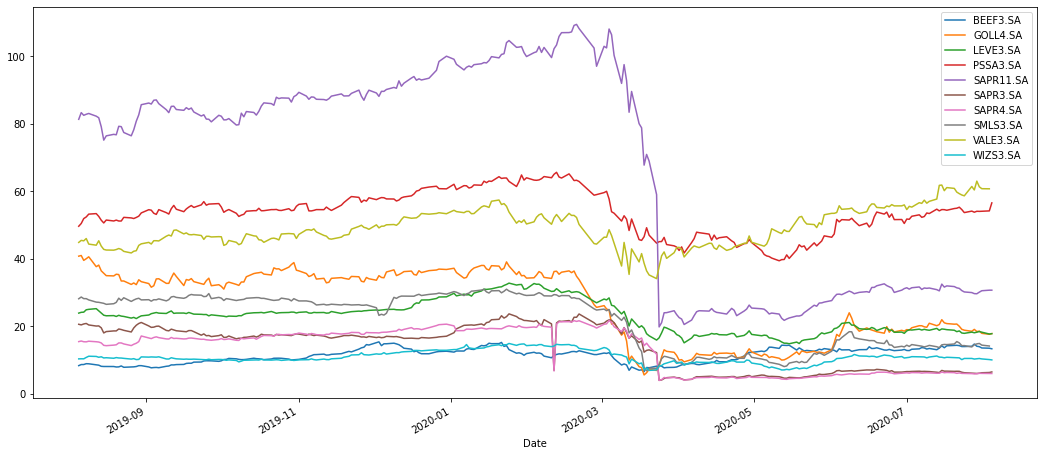

In [28]:
# Gráfico das ações baratas no último ano #
dados1.plot(figsize=(18,8))

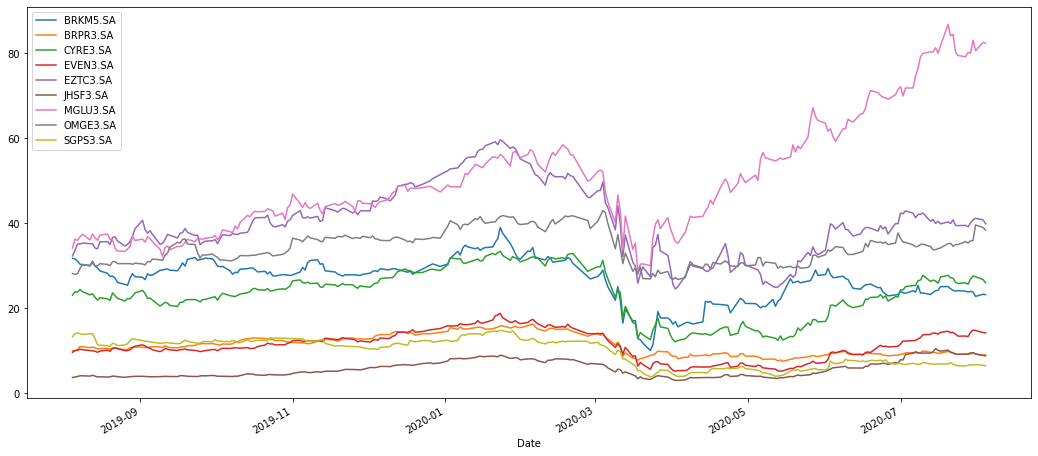

In [29]:
# Gráfico das ações caras no último ano #
dados2.plot(figsize=(18,8))

In [33]:
ibov.tail()

Date
2020-07-29    1.051933
2020-07-30    1.050171
2020-07-31    1.029232
2020-08-03    1.029025
2020-08-04    1.021354
Name: Adj Close, dtype: float64

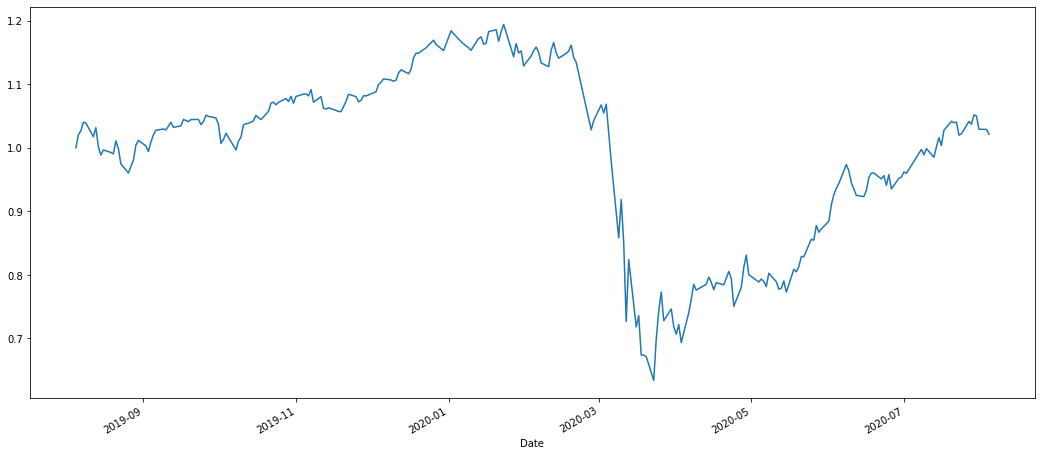

In [31]:
# Gráfico do indice BOVA11 no último ano #
ibov.plot(figsize=(18,8))

#Fim

In [32]:
header = {
  "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36"  
 }

r = requests.get(url, headers=header)